In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vinayreddy2003","key":"03ed01c5b089ca629c4a93c92688326b"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d tongpython/cat-and-dog -p /content/data

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
 93% 202M/218M [00:00<00:00, 433MB/s]
100% 218M/218M [00:00<00:00, 465MB/s]


In [5]:
!unzip -q /content/data/cat-and-dog.zip -d /content/data/

In [6]:
cat_train_dir = '/content/data/training_set/training_set/cats'
dog_train_dir = '/content/data/training_set/training_set/dogs'

cat_test_dir = '/content/data/test_set/test_set/cats'
dog_test_dir = '/content/data/test_set/test_set/dogs'

In [7]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

IMG_SIZE = (128, 128)

def load_images(folder, label, limit=None):
    imgs, labels = [], []
    files = os.listdir(folder)
    files = files[:limit] if limit else files
    for fname in files:
        # Only process image files
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        path = os.path.join(folder, fname)
        img = cv2.imread(path)
        if img is None:  # skip corrupted or unreadable files
         continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        img = img.astype('float32') / 255.0
        imgs.append(img)
        labels.append(label)
    return np.array(imgs), np.array(labels)

# Load a subset for quick testing
X_cats, y_cats = load_images(cat_train_dir, 0, limit=1000)
X_dogs, y_dogs = load_images(dog_train_dir, 1, limit=1000)

# Merge cats & dogs
X = np.concatenate([X_cats, X_dogs], axis=0)
y = np.concatenate([y_cats, y_dogs], axis=0)

print("Full dataset shape:", X.shape, y.shape)


Full dataset shape: (1998, 128, 128, 3) (1998,)


In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)

Train: (1598, 128, 128, 3) (1598,)
Val: (400, 128, 128, 3) (400,)


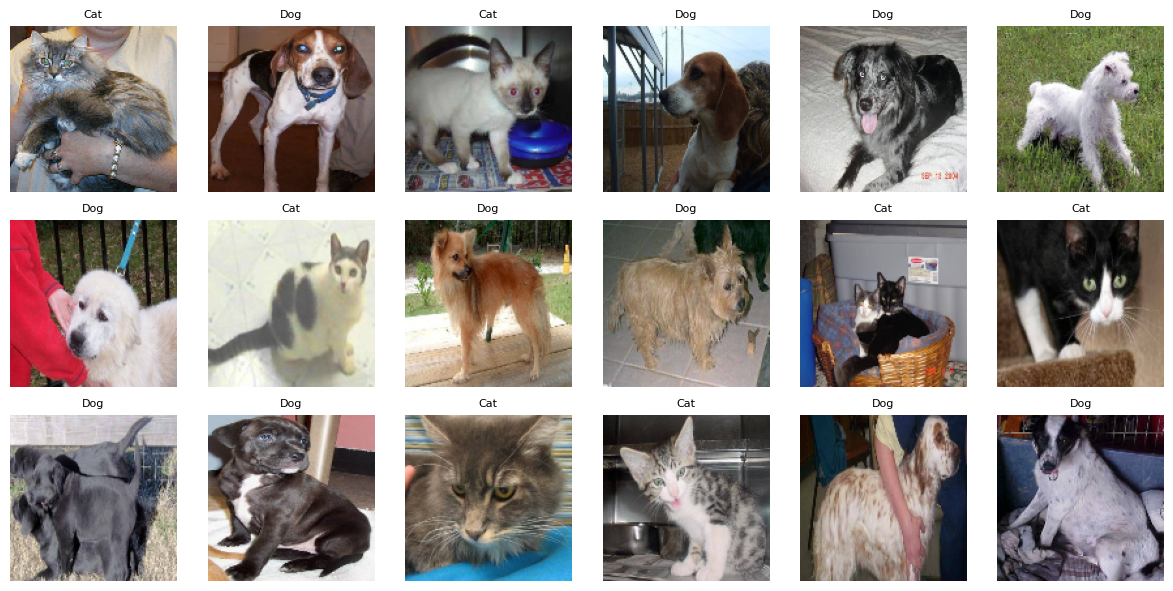

In [9]:
import matplotlib.pyplot as plt

def show_samples(imgs, labels, rows=3, cols=6):
    fig, axs = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axs = axs.flatten()
    for i in range(rows*cols):
        axs[i].imshow(imgs[i])
        axs[i].set_title("Cat" if labels[i]==0 else "Dog", fontsize=8)
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

show_samples(X_train, y_train)


In [10]:
## day 2

In [11]:
#Build the CNN model
import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = 2  # Cat or Dog

model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.4806 - loss: 0.8305 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5310 - loss: 0.6890 - val_accuracy: 0.5000 - val_loss: 0.7036
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5631 - loss: 0.6839 - val_accuracy: 0.5800 - val_loss: 0.6768
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6199 - loss: 0.6486 - val_accuracy: 0.5850 - val_loss: 0.6682
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6860 - loss: 0.5882 - val_accuracy: 0.6275 - val_loss: 0.6380
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6965 - loss: 0.5642 - val_accuracy: 0.6650 - val_loss: 0.6378
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7796 - loss: 0.4771 - val_accuracy: 0.6575 - val_loss: 0.6250
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8279 - loss: 0.3728 - val_accuracy: 0.6900 -

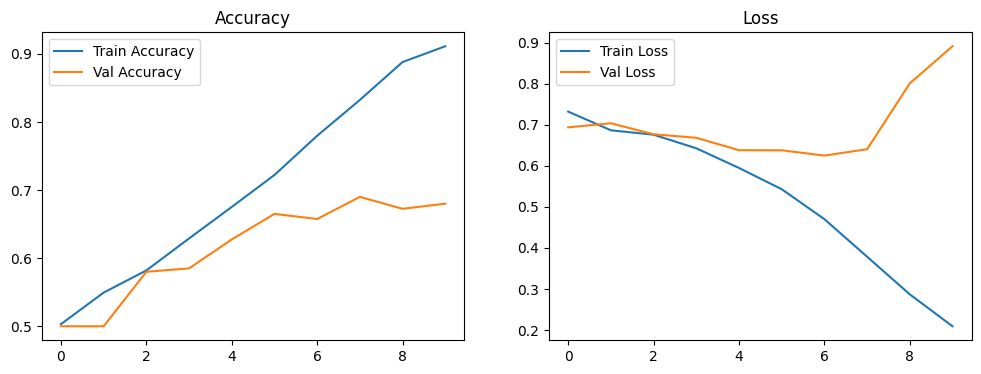

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()

In [14]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6727 - loss: 0.8846
Validation Accuracy: 68.00%


In [15]:
model.save('cats_dogs_baseline.keras')

In [16]:
## Day 3

In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Create Data Augmentation Generators
# For the training data, we'll apply various augmentations.
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For the validation data, we only need to rescale it. No augmentation!
val_datagen = ImageDataGenerator() # Rescaling is already done in the initial preprocessing

# Create data generators from our data
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

In [18]:
# 2. Re-train the CNN Model with Augmented Data
# We'll use the same model architecture as before.
model_augmented = tf.keras.models.clone_model(model)
model_augmented.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

print("\n--- Training with Data Augmentation ---")
history_augmented = model_augmented.fit(
    train_generator,
    epochs=15,  # Let's train for a few more epochs
    validation_data=val_generator
)


--- Training with Data Augmentation ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - accuracy: 0.4989 - loss: 0.8409 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.5074 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.5034 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.4985 - loss: 0.6926 - val_accuracy: 0.5375 - val_loss: 0.6916
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.5099 - loss: 0.6921 - val_accuracy: 0.5000 - val_loss: 0.6907
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.5148 - loss: 0.6940 - val_accuracy: 0.5375 - val_loss: 0.6911
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.5149 - loss: 0.6945 - val_accuracy: 0.5000 - val_loss: 0.6975
Epoch 8/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - accuracy: 0.5538 - loss: 0.6906 - val_accuracy: 0

In [18]:
# 3. Evaluate the Augmented Model
print("\n--- Augmented Model Evaluation ---")
val_loss_aug, val_acc_aug = model_augmented.evaluate(X_val, y_val)
print(f"Validation Accuracy with Augmentation: {val_acc_aug*100:.2f}%")

# Plot the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_augmented.history['accuracy'], label='Train Accuracy')
plt.plot(history_augmented.history['val_accuracy'], label='Val Accuracy')
plt.title('Augmented Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_augmented.history['loss'], label='Train Loss')
plt.plot(history_augmented.history['val_loss'], label='Val Loss')
plt.title('Augmented Model Loss')
plt.legend()
plt.show()

In [19]:
## day 4

In [23]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, layers

# 1. Load the Pre-trained Base Model (MobileNetV2)
# We'll use the weights from 'imagenet' and exclude the top classification layer.
base_model = MobileNetV2(input_shape=(128, 128, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the base model's layers so they aren't re-trained
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [24]:
# 2. Build the New Model on Top of the Base
transfer_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), # Reduces the spatial dimensions
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), # Helps prevent overfitting
    layers.Dense(num_classes, activation='softmax') # Our output layer
])

In [25]:
# 3. Compile the Transfer Learning Model
transfer_model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

transfer_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [26]:
# 4. Train the Transfer Learning Model
print("\n--- Training with Transfer Learning (MobileNetV2) ---")
history_transfer = transfer_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)


--- Training with Transfer Learning (MobileNetV2) ---
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 245ms/step - accuracy: 0.8468 - loss: 0.3620 - val_accuracy: 0.9700 - val_loss: 0.0941
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9675 - loss: 0.0976 - val_accuracy: 0.9650 - val_loss: 0.0878
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9779 - loss: 0.0517 - val_accuracy: 0.9650 - val_loss: 0.0883
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9873 - loss: 0.0391 - val_accuracy: 0.9725 - val_loss: 0.0695
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9870 - loss: 0.0321 - val_accuracy: 0.9700 - val_loss: 0.0880
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9919 - loss: 0.0202 - val_accuracy: 0.9650 - val_loss: 0.0825
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9914 - loss: 0.0231 - val_accuracy: 0.9675 - val_loss: 0.0742
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - a


--- Transfer Learning Model Evaluation ---
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9650 - loss: 0.0914
Validation Accuracy with Transfer Learning: 97.00%


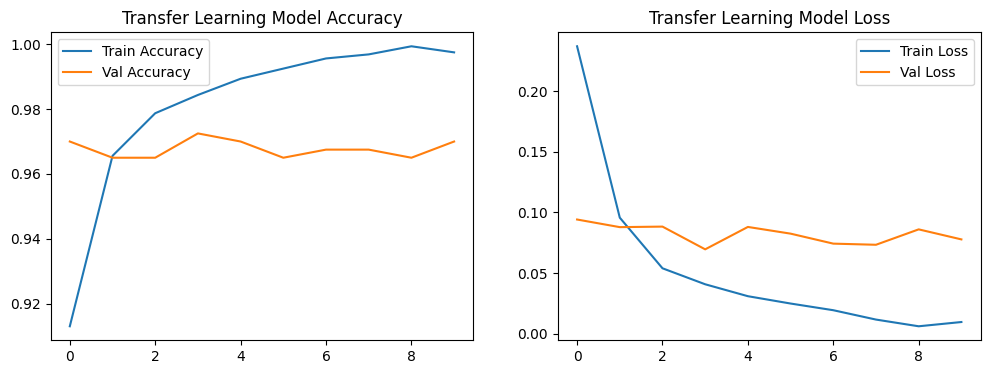

In [27]:
# 5. Evaluate the Transfer Learning Model
print("\n--- Transfer Learning Model Evaluation ---")
val_loss_transfer, val_acc_transfer = transfer_model.evaluate(X_val, y_val)
print(f"Validation Accuracy with Transfer Learning: {val_acc_transfer*100:.2f}%")

# Plot the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='Train Accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='Val Accuracy')
plt.title('Transfer Learning Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='Train Loss')
plt.plot(history_transfer.history['val_loss'], label='Val Loss')
plt.title('Transfer Learning Model Loss')
plt.legend()
plt.show()

TESTING

In [28]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load Test Images with the CORRECT size ---
# Ensure IMG_SIZE is the same as when you trained the model
IMG_SIZE = (128, 128)

# Re-load the test images, ensuring they are resized to 128x128
X_cats_test, y_cats_test = load_images(cat_test_dir, 0, limit=25)
X_dogs_test, y_dogs_test = load_images(dog_test_dir, 1, limit=25)

X_test = np.concatenate([X_cats_test, X_dogs_test], axis=0)
y_test = np.concatenate([y_cats_test, y_dogs_test], axis=0)

print("Corrected Test dataset shape:", X_test.shape, y_test.shape)

Corrected Test dataset shape: (50, 128, 128, 3) (50,)


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step

--- Classification Report ---
              precision    recall  f1-score   support

         Cat       1.00      0.96      0.98        25
         Dog       0.96      1.00      0.98        25

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50


--- Confusion Matrix ---


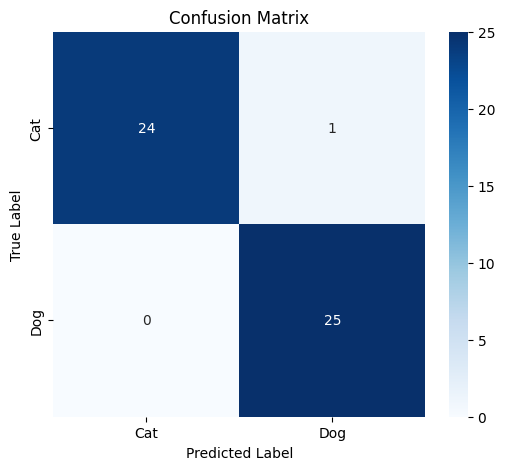

In [29]:
# --- 2. Make Predictions and Get a Detailed Report ---
# This part will now work correctly

# Get model predictions
predictions = transfer_model.predict(X_test)
y_pred = np.argmax(predictions, axis=1) # Get the class with the highest probability

# Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Cat', 'Dog']))

# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [33]:
def show_predictions(imgs, true_labels, predicted_labels, rows=3, cols=6):
    fig, axs = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axs = axs.flatten()
    for i in range(rows*cols):
        axs[i].imshow(imgs[i])
        true_label = "Cat" if true_labels[i] == 0 else "Dog"
        predicted_label = "Cat" if predicted_labels[i] == 0 else "Dog"
        color = "green" if true_labels[i] == predicted_labels[i] else "red"
        axs[i].set_title(f"True: {true_label}\nPred: {predicted_label}", fontsize=8, color=color)
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()


--- Visualizing a Shuffled Mix of Predictions ---


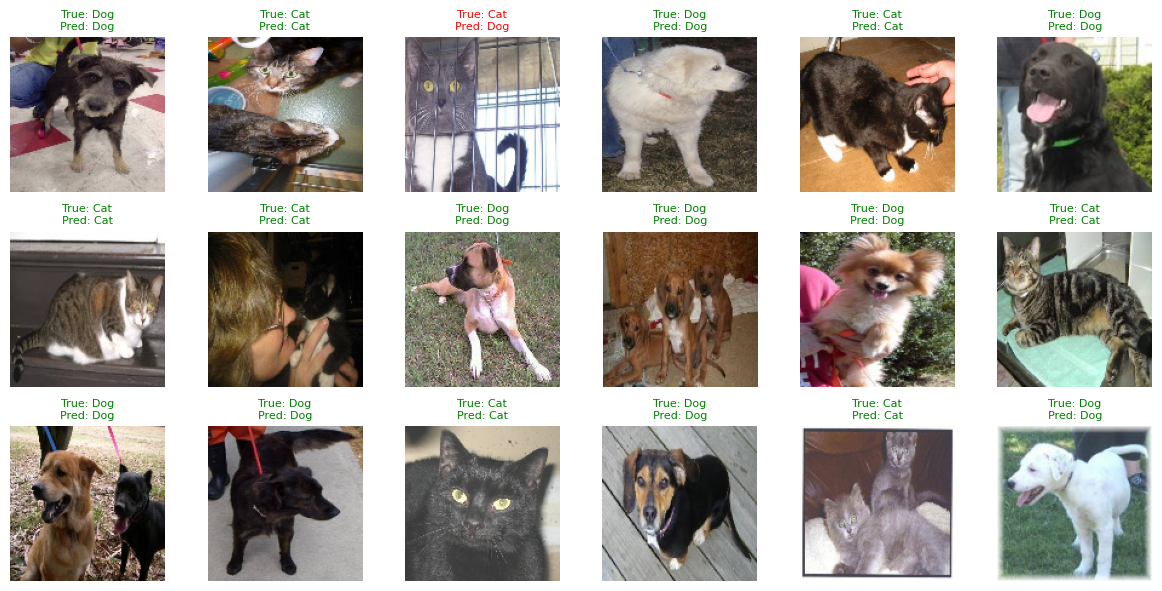

In [34]:
import numpy as np

# Create a set of shuffled indices
indices = np.arange(X_test.shape[0])
np.random.shuffle(indices)

# Reorder the images, true labels, and predicted labels using the same shuffled indices
X_test_shuffled = X_test[indices]
y_test_shuffled = y_test[indices]
y_pred_shuffled = y_pred[indices]


# --- Visualize the SHUFFLED Predictions ---
# Now, you'll see a mix of cats and dogs
print("\n--- Visualizing a Shuffled Mix of Predictions ---")
show_predictions(X_test_shuffled, y_test_shuffled, y_pred_shuffled, rows=3, cols=6)

In [35]:
#  Evaluate the Transfer Learning Model
print("\n--- Transfer Learning Model Evaluation ---")
val_loss_transfer, val_acc_transfer = transfer_model.evaluate(X_val, y_val)
print(f"Validation Accuracy with Transfer Learning: {val_acc_transfer*100:.2f}%")


--- Transfer Learning Model Evaluation ---
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9650 - loss: 0.0914
Validation Accuracy with Transfer Learning: 97.00%


In [36]:
transfer_model.save('cats_dogs_transfer_learning.keras')

In [39]:
transfer_model.save("mobilenetv2_cats_dogs.keras")

In [48]:

import tensorflow as tf
import numpy as np
import cv2
from google.colab import files

# Load your trained MobileNetV2 model
model = tf.keras.models.load_model("mobilenetv2_cats_dogs.keras")

IMG_SIZE = (128, 128)  # Size used during training

def predict_image(img_path):

    # Read and preprocess
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Predict
    prediction = model.predict(img)
    class_idx = np.argmax(prediction, axis=1)[0]
    label = "Cat" if class_idx == 0 else "Dog"
    confidence = np.max(prediction) * 100
    return label, confidence

# Ask user to upload image
print("Please upload an image:")
uploaded = files.upload()

# Run prediction for each uploaded image
for filename in uploaded.keys():
    label, conf = predict_image(filename)
    print(f"{filename} → Prediction: {label} ({conf:.2f}%)")

Please upload an image:


Saving 3542.webp to 3542 (2).webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
3542 (2).webp → Prediction: Cat (100.00%)
